In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-movie-reviews/IMDB Dataset.csv


# **Important Libraries**

In [3]:
# Important Libraries
import string
import numpy as np
import pandas as pd
import re
import unicodedata
import html
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import subprocess
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('omw-1.4')
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package wordnet to /kaggle/working/...


# **Load Dataset**

In [4]:
df=pd.read_csv(r'/kaggle/input/imdb-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Chech for Duplicated Values
df.duplicated().sum()

418

In [7]:
# Remove it 
df.drop_duplicates(inplace=True)

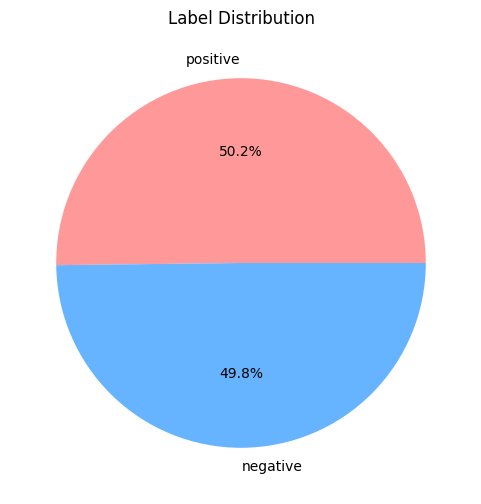

In [8]:
# Overall Label distribution
label_counts = df['sentiment'].value_counts()

plt.figure(figsize=(6, 6))
label_counts.plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
plt.title("Label Distribution")
plt.ylabel("") 
plt.show()

# **Spliting and Preprocessing**

In [9]:
X=df['review']
y=df['sentiment'].map({'positive':1,'negative':0})

In [10]:
def normalize_text(text):
    """
    Normalize text by removing special characters, HTML tags, URLs, stopwords, and applying lemmatization.
    """
    stop_words = set(stopwords.words('english'))
    # Remove special characters and HTML entities
    re1 = re.compile(r'  +')
    text = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'") \
        .replace('nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'") \
        .replace('<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.') \
        .replace(' @-@ ', '-').replace('\\', ' \\ ')
    text = re1.sub(' ', html.unescape(text))
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove emails
    text = re.sub(r'\S+@\S+\.\S+', '', text)
    # Remove emojis
    text = re.sub(r'[\U00010000-\U0010FFFF]', '', text, flags=re.UNICODE)
    # Remove non-ASCII characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    # Replace numbers with empty string
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    # Lemmatize verbs
    words = [lemmatizer.lemmatize(word, pos='v') for word in words]
    return ' '.join(words)

In [11]:
# Preprocessing Text
X=X.apply(normalize_text)
X.head()

0    one reviewer mention watch oz episode youll ho...
1    wonderful little production film technique una...
2    think wonderful way spend time hot summer week...
3    basically there family little boy jake think t...
4    petter matteis love time money visually stun f...
Name: review, dtype: object

In [12]:
# Making Training and Testing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((39665,), (9917,), (39665,), (9917,))

# **Bert Embeddings**

In [13]:
# Load BERT Tokenizer and Model
bert_model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [14]:
# Create Custom Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len=100):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Create Train and Test Datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_len=100)
test_dataset = SentimentDataset(X_test, y_test, tokenizer, max_len=100)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# **Model**

In [15]:
class SentimentBERT(nn.Module):
    def __init__(self, bert_model, hidden_dim, output_dim):
        super(SentimentBERT, self).__init__()
        self.bert = bert_model
        self.dropout1 = nn.Dropout(0.3)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_dim // 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout1(pooled_output)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.sigmoid(x)

In [16]:
# Initialize Model
hidden_dim = 768
output_dim = 1
model = SentimentBERT(bert_model, hidden_dim, output_dim)

# Move Model to Device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Define Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [17]:
# Train Model
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    with tqdm(train_loader, unit="batch", desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
        for batch in tepoch:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].unsqueeze(1).to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask).squeeze()
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            tepoch.set_postfix(loss=total_loss / (tepoch.n + 1))

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

Epoch 1/5: 100%|██████████| 2480/2480 [08:31<00:00,  4.85batch/s, loss=0.365]


Epoch 1, Loss: 0.3645


Epoch 2/5: 100%|██████████| 2480/2480 [08:30<00:00,  4.85batch/s, loss=0.228]


Epoch 2, Loss: 0.2277


Epoch 3/5: 100%|██████████| 2480/2480 [08:31<00:00,  4.85batch/s, loss=0.128]


Epoch 3, Loss: 0.1282


Epoch 4/5: 100%|██████████| 2480/2480 [08:30<00:00,  4.85batch/s, loss=0.0639]


Epoch 4, Loss: 0.0639


Epoch 5/5: 100%|██████████| 2480/2480 [08:31<00:00,  4.85batch/s, loss=0.0443]

Epoch 5, Loss: 0.0443


In [18]:
# Evaluate Model
model.eval()
all_predictions, all_labels = [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].unsqueeze(1).to(device)

        outputs = model(input_ids, attention_mask).squeeze()
        predictions = (outputs > 0.3298).float()

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate Metrics
accuracy = np.mean(np.array(all_predictions) == np.array(all_labels))
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

print(f'Test Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC-ROC: {roc_auc:.4f}')

Evaluating: 100%|██████████| 620/620 [00:55<00:00, 11.09it/s]


Test Accuracy: 0.5000
F1 Score: 0.8840
AUC-ROC: 0.8842


In [23]:
# Select Example Reviews from Test Dataset
example_indices = [10, 100, 200]  # Example indices from the test dataset
example_reviews = [X_test.iloc[i] for i in example_indices]
example_labels = [y_test.iloc[i] for i in example_indices]

In [24]:
# Predict Sentiment 
def predict_sentiment(review, model, tokenizer, threshold=0.3298, device=device):
    model.eval()
    encoded_input = tokenizer([review], padding=True, truncation=True, max_length=100, return_tensors="pt")
    encoded_input = {key: val.to(device) for key, val in encoded_input.items()}

    with torch.no_grad():
        outputs = model(encoded_input['input_ids'], encoded_input['attention_mask']).squeeze()
        prediction = (outputs > threshold).float().item()

    return "Positive" if prediction == 1 else "Negative"

In [25]:
# Ensure the model is on the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device) 

# Make Predictions
for i, (review, label) in enumerate(zip(example_reviews, example_labels)):
    sentiment = predict_sentiment(review, model, tokenizer)
    true_label = "Positive" if label == 1 else "Negative"
    print(f"Example {i+1}: '{review[:50]}...' -> Predicted: {sentiment}, True: {true_label}")

Example 1: 'one latest disaster movie york entertainment el ch...' -> Predicted: Negative, True: Negative
Example 2: 'th movie karate kid serieshowever nothing previous...' -> Predicted: Positive, True: Positive
Example 3: 'realistic movie realistic ive see urban youth acto...' -> Predicted: Positive, True: Positive
